In [1]:
### Some initializations
import numpy as np
import math
import random
import copy
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import warnings
import itertools
from Main_full import main
from heapq import nlargest
from sklearn.cluster import KMeans

In [3]:
def main_gauss(x,y,B,l):
    E=len(x)
    n,d=x[0].shape
    temp=[list(itertools.combinations(range(d), k)) for k in range(0,d)]
    subsets = [item for sublist in temp for item in sublist]
    dic={}
    S_ini=[]
    for ind in subsets:
        ind=np.array(ind)
        Res=np.zeros(E)
        T_mc=np.zeros((E,B))
        for i in range(E):
            n,d=x[i].shape
            if len(ind)==0:
                Res[i]=np.sum((y[i]-np.mean(y[i]))**2)
#                 Res[i]=np.sum((y[i])**2)
            else:
#                 xtemp=x[i][:,ind]
                xtemp=copy.copy(x[i][:,ind])
                xtemp=np.concatenate((xtemp,np.ones((n,1))),axis=1)
                beta_hat=np.linalg.inv(xtemp.T@xtemp)@(xtemp.T)@y[i]
                Res[i]=np.sum((y[i]-xtemp@beta_hat)**2)
                T_mc[i,:]=(np.random.chisquare(n-len(ind),B))
        T_b=np.sort(T_mc,kind='mergesort',axis=0)
        T_data=np.sort(Res,kind='mergesort')
        pval=1/B*np.sum(np.sum(T_data[:l])*np.sum(T_b[-l:,:],axis=0)>np.sum(T_b[:l,:],axis=0)*np.sum(T_data[-l:]))
#         print(ind)
#         print(pval)
        if pval>0.05:
            S_ini.append(ind)
    return [set(S_ini[k]) for k in range(len(S_ini))]

In [4]:
### First test, noise to signal ratio
np.random.seed(0)
d=5  #Dimensionality
supp=(0,1) #support indices
s=len(supp)  #Number of support entries
noisetosignal=[0.001,0.01,0.1,0.5,2,5,10]  #Sample Sizes
signal=[0.01,0.1,0.5,1,2,5]
fn=np.zeros((len(noisetosignal),len(signal)))
fp=np.zeros((len(noisetosignal),len(signal)))
runs=10
n=50 # Sample size
l=1 # Number of intervals we combine for the statistics
B=100 # Bootstrap runs
I=30      #Number of Intervals 
a=[list(itertools.combinations(range(d), k)) for k in range(0,d+1)]
subsets = [item for sublist in a for item in sublist]
dic={}
# We first fix the data for all runs, to eliminate the randomness of this.
X=[]
Y=[]
for r in range(runs):
    betas=np.zeros((I,d))
    X.append([])
    Y.append([])
    for i in range(I):
        x=np.zeros((n,d))
        y=np.zeros((n))
        a=np.random.uniform(low=1,high=5,size=(d))
#         b=np.random.uniform(low=-30,high=0,size=(d))
        for p in range(d):
            x[:,p]=np.random.normal(scale=a[p],size=(n))
        betas[i,:s]=np.random.uniform(low=1,high=5,size=(s))
        X[r].append(x)
        Y[r].append(y)

for o,nts in enumerate(noisetosignal):
    print('Noise to singal ratio',o+1,'of',len(noisetosignal))
    for p,sig in enumerate(signal):
        noise=nts/sig
        for r in range(runs):
            for i in range(I):
                e=np.random.multivariate_normal(0*np.ones(n),noise*np.eye(n))
                Y[r][i]=X[r][i]@(sig*betas[i,:])+e


            plausibleS=main_gauss(X[r],Y[r],B,l)
            if not not plausibleS:
                if tuple(set.intersection(*plausibleS))==supp:
                    success[o,p]+=1
success=success/runs
fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
plt.scatter(noisetosignal,np.mean(success,axis=1))
plt.xlabel('Sample Size',fontsize=14)
plt.ylabel('Success Rate',fontsize=14)
plt.savefig('andersIID.eps', format='eps')

Noise to singal ratio 1 of 7


NameError: name 'success' is not defined

Sample Size 1 of 3
Sample Size 2 of 3
Sample Size 3 of 3


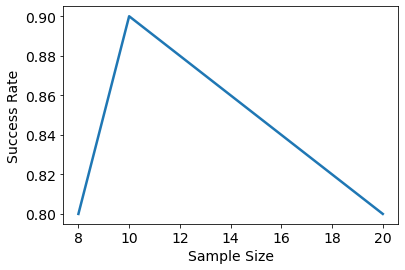

In [117]:
### First test, noise to signal ratio
# np.random.seed(0)
d=5  #Dimensionality
supp=(0,1) #support indices
s=len(supp)  #Number of support entries
samples=[8,10,20]  #Sample Sizes
success=np.zeros(len(samples))
runs=10
l=1 # Number of intervals we combine for the statistics
B=100 # Bootstrap runs
I=30      #Number of Intervals 
a=[list(itertools.combinations(range(d), k)) for k in range(0,d)]
subsets = [item for sublist in a for item in sublist]
dic={}
for o,n1 in enumerate(samples):
    print('Sample Size',o+1,'of',len(samples))
    for r in range(runs):
        betas=np.zeros((I,d))
        X=[]
        Y=[]
        for i in range(I):
            n=np.random.randint(n1,n1+20)
            x=np.zeros((n,d))
            y=np.zeros((n))
            b=np.random.uniform(low=0,high=30,size=(d))
            a=np.random.uniform(low=-30,high=0,size=(d))
            for p in range(d):
                x[:,p]=np.random.uniform(low=a[p],high=b[p],size=(n))
            betas[i,:s]=np.random.uniform(low=-1,high=4,size=(s))
            e=np.random.multivariate_normal(1*np.ones(n),np.eye(n))
#             e=np.random.uniform(low=-0.5,high=0.5,size=(n))
            y[:]=x[:,:]@betas[i,:]+e
            x[:,4]=betas[i,0]*y[:]+np.random.uniform(low=a[p],high=b[p],size=(n))
            X.append(x)
            Y.append(y)

      
        plausibleS=main_gauss(X,Y,B,l)
        if not not plausibleS:
            if tuple(set.intersection(*plausibleS))==supp:
                success[o]+=1
success=success/runs
fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
plt.plot(samples,success,linewidth=2.5)
plt.xlabel('Sample Size',fontsize=14)
plt.ylabel('Success Rate',fontsize=14)
plt.savefig('andersIID.eps', format='eps')

In [17]:
def shuffle(x,B):
    E=len(x)
    x_shuffle=[]
    for e in range(E):
        n,d=x[e].shape
        x_temp=np.zeros((B,n,d))
        for b in range(B):
            for i in range(d):
                c=(x[e][:,i].T).flatten()
                np.random.shuffle(c)
                x_temp[b,:,i]=c
        x_shuffle.append(x_temp)
        
    return x_shuffle
    

In [128]:
def main_noassumption(x,y,B,l):
    S1=[0,1,2,3,4]
    E=len(x)
    lam=0
    n,d=x[0].shape
    temp=[list(itertools.combinations(range(d), k)) for k in range(0,d)]
    subsets = [item for sublist in temp for item in sublist]
    dic={}
    S_ini=[]
    x_shuffle=shuffle(x,B)
    for ind in subsets:
        Res=np.zeros((E,B))
        T_mc=np.zeros((E,B))
        for i in range(E):
            n,d=x[i].shape
            if len(ind)==0:
#                 Res[i]=np.sum((y[i]-np.mean(y[i]))**2)
                Res[i]=np.sum((y[i])**2)
            else:
                comp=list(set(S1)-set(ind))
                xtemp=copy.copy(x[i])
                for b in range(B):
                    xtemp[:,comp]=(x_shuffle[i][b,:,comp]).T
                    beta_hat=np.linalg.inv(xtemp.T@xtemp+lam*np.eye(d))@(xtemp.T)@y[i]
                    Res[i,b]=np.sum((y[i]-xtemp@beta_hat)**2)
#         T_data=np.var(Res,axis=0)
        T_data=100*np.min(Res,axis=0)/np.max(Res,axis=0)
        print(ind)
        print(np.median(T_data),np.mean(T_data),np.std(T_data))
#         if something:
#             S_ini.append(ind)
    return [set(S_ini[k]) for k in range(len(S_ini))]

In [202]:
mc=1000
k=4
E=100000
p=0
for i in range(mc):
    a=np.random.chisquare(k,E)
    b=np.random.chisquare(k,E)
    
    if np.max((np.min(a),1))/np.max(a)<0.8*np.max((np.min(b),1))/np.max(b):
        p+=1/mc
print(p)
    

0.03400000000000002


In [197]:
np.max((np.min(a),0.1))

1.15948761569696

In [162]:
n=1000
k=10
X=np.random.normal(scale=2,size=[n,1])
Y=2*X**2+np.random.normal(scale=0.6,size=[n,1])
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)

x=[]
y=[]
# create the KMeans object with k clusters and fit the data X
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
for c in range(k):
    cluster_indices = np.where(kmeans.labels_ == c)[0]
    x.append(X[cluster_indices])
    y.append(Y[cluster_indices])
# retrieve the data points from X that belong to cluster label k
# Xc = X[cluster_indices]
# Yc=Y[cluster_indices]
# b=np.linalg.inv(Xc.T@Xc)@Xc.T@Yc
# res=Yc-b*Xc
# B=100
# l=5
# plt.scatter(Xc,res)

In [215]:

# xtemp=np.concatenate((xtemp,np.zeros((n,1))),axis=1)
xtemp

array([[5.42385286, 0.        ],
       [4.74318517, 0.        ],
       [4.86946387, 0.        ],
       [5.34522992, 0.        ],
       [5.62095453, 0.        ],
       [4.3993544 , 0.        ],
       [4.30564592, 0.        ],
       [4.35750192, 0.        ],
       [4.31998923, 0.        ],
       [5.92559291, 0.        ],
       [5.06697334, 0.        ],
       [5.38086121, 0.        ],
       [4.14253903, 0.        ]])

In [218]:
E=len(x)
l=2
n,d=x[0].shape
temp=[list(itertools.combinations(range(d), k)) for k in range(0,d+1)]
subsets = [item for sublist in temp for item in sublist]
dic={}
for ind in subsets:
    R=[]
    for i in range(E):
        n,d=x[i].shape
        if len(ind)==0:
            R.append(y[i]-np.mean(y[i]))
        else:
            xtemp=x[i][:,ind]
            xtemp=np.concatenate((xtemp,np.ones((n,1))),axis=1)
            ind=np.array(ind)
            beta_hat=np.linalg.inv(xtemp.T@xtemp)@(xtemp.T)@y[i]
            R.append(y[i]-xtemp@beta_hat)
    dic[tuple(ind)]=copy.copy(R)
S_ini=[]
for k in dic:
    Res=dic[k]
    pval=0
    n=len(Res)
    for b in range(B):
        a=np.random.chisquare(n-len(k),E)
        T=[np.sum(r**2) for r in Res]
#                 if np.min(T)/np.max(T)>np.min(a)/np.max(a):
#                     pval+=1/B
        T_b=np.sort(a,kind='mergesort')
        T_data=np.sort(T,kind='mergesort')
        if np.sum(T_data[:l])/np.sum(T_data[-l:])>np.sum(T_b[:l])/np.sum(T_b[-l:]):
            pval+=1/B
    print(k)
    print(pval)
    if pval>0.05:
        S_ini.append(k)
print([set(S_ini[k]) for k in range(len(S_ini))])

()
0
(0,)
0.24000000000000007
[{0}]


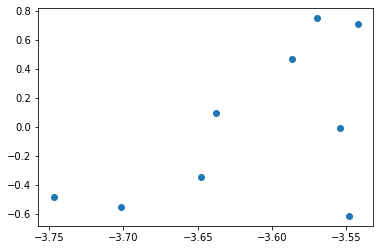

In [111]:
Xc = x[30]
Yc=y[30]
b=np.linalg.inv(Xc.T@Xc)@Xc.T@Yc
res=Yc-b*Xc
plt.scatter(Xc,res)

In [124]:
e=np.random.multivariate_normal(np.zeros(n),np.eye(n))
# e=np.random.uniform(low=-0.5,high=0.5,size=(n,1))
e.shape

(6,)

Sample Size 1 of 4
Sample Size 2 of 4
Sample Size 3 of 4
Sample Size 4 of 4


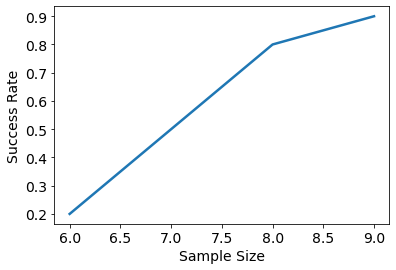

In [11]:
### Here we use i.i.d data to create Figure 1a
np.random.seed(0)
d=5  #Dimensionality
s=2  #Number of support entries
samples=[6,7,8,9]  #Sample Sizes
success=np.zeros(len(samples))
runs=10
l=1 # Number of intervals we combine for the statistics
B=100 # Bootstrap runs
I=20      #Number of Intervals 
lam=0   #Lambda
a=[list(itertools.combinations(range(d), k)) for k in range(0,d)]
subsets = [item for sublist in a for item in sublist]
dic={}
for o,n in enumerate(samples):
    print('Sample Size',o+1,'of',len(samples))
    for r in range(runs):
        x=np.zeros((I,n,d))
        y=np.zeros((I,n))
        betas=np.zeros((I,d))
        R=np.zeros((I,n))
        for i in range(I):
            b=np.random.uniform(low=0,high=30,size=(d))
            a=np.random.uniform(low=-30,high=0,size=(d))
            for p in range(d):
                x[i,:,p]=np.random.uniform(low=a[p],high=b[p],size=(n))
            betas[i,:s]=np.random.uniform(low=-1,high=4,size=(s))
            e=np.random.multivariate_normal(np.zeros(n),np.eye(n))
            y[i,:]=x[i,:,:]@betas[i,:]+e
            x[i,:,4]=betas[i,0]*y[i,:]+np.random.uniform(low=a[p],high=b[p],size=(n))

        for ind in subsets:
            for i in range(I):
                if len(ind)==0:
                    R[i,:]=y[i,:]
                else:
                    ind=np.array(ind)
                    beta_hat=np.linalg.inv(x[i,:,ind]@x[i,:,ind].T+lam*np.eye(len(ind)))@(x[i,:,ind])@y[i,:]
                    R[i,:]=y[i,:]-x[i,:,ind].T@beta_hat
            dic[tuple(ind)]=copy.copy(R)
        S_ini=[]
        for k in dic:
            Res=dic[k]
            pval=0
            for b in range(B):
                a=np.random.chisquare(n-len(k),I)
                T=np.sum(Res**2,axis=1)
#                 if np.min(T)/np.max(T)>np.min(a)/np.max(a):
#                     pval+=1/B
                T_b=np.sort(a,kind='mergesort')
                T_data=np.sort(T,kind='mergesort')
                if np.sum(T_data[:l])/np.sum(T_data[-l:])>np.sum(T_b[:l])/np.sum(T_b[-l:]):
                    pval+=1/B
            if pval>0.05:
                S_ini.append(k)
        plausibleS=[set(S_ini[k]) for k in range(len(S_ini))]
        if not not plausibleS:
            if tuple(set.intersection(*plausibleS))==(0,1):
                success[o]+=1
success=success/runs
fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
plt.plot(samples,success,linewidth=2.5)
plt.xlabel('Sample Size',fontsize=14)
plt.ylabel('Success Rate',fontsize=14)
plt.savefig('andersIID.eps', format='eps')

In [ ]:
a=Res.flatten()
print(a[:2])
print(a[-2:])

Sample Size 1 of 3


/tmp/ipykernel_153/638891303.py:41: UserWarning: p-value floored: true value smaller than 0.001
  pval=scipy.stats.anderson_ksamp(Res)[2]
/tmp/ipykernel_153/638891303.py:41: UserWarning: p-value capped: true value larger than 0.25
  pval=scipy.stats.anderson_ksamp(Res)[2]


Sample Size 2 of 3
Sample Size 3 of 3


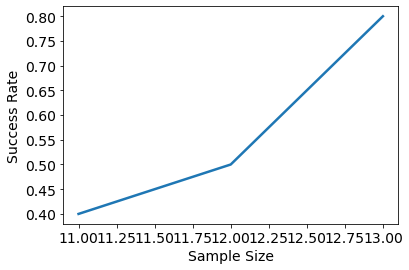

In [5]:
### Here we use i.i.d data to create Figure 1a
np.random.seed(0)
d=5  #Dimensionality
s=2  #Number of support entries
samples=[11,12,13]  #Sample Sizes
success=np.zeros(len(samples))
runs=10
I=10     #Number of Intervals 
lam=0   #Lambda
a=[list(itertools.combinations((0,1,2,3,4), k)) for k in range(0,d)]
subsets = [item for sublist in a for item in sublist]
dic={}
for o,n in enumerate(samples):
    print('Sample Size',o+1,'of',len(samples))
    for r in range(runs):
        x=np.zeros((I,n,d))
        y=np.zeros((I,n))
        betas=np.zeros((I,d))
        R=np.zeros((I,n))
        for i in range(I):
            b=np.random.uniform(low=0,high=30,size=(d))
            a=np.random.uniform(low=-30,high=0,size=(d))
            for p in range(d):
                x[i,:,p]=np.random.uniform(low=a[p],high=b[p],size=(n))
            betas[i,:s]=np.random.uniform(low=-1,high=4,size=(s))
            e=np.random.multivariate_normal(np.zeros(n),np.eye(n))
            y[i,:]=x[i,:,:]@betas[i,:]+e

        for ind in subsets:
            for i in range(I):
                if len(ind)==0:
                    R[i,:]=y[i,:]
                else:
                    ind=np.array(ind)
                    beta_hat=np.linalg.inv(x[i,:,ind]@x[i,:,ind].T+lam*np.eye(len(ind)))@(x[i,:,ind])@y[i,:]
                    R[i,:]=y[i,:]-x[i,:,ind].T@beta_hat
            dic[tuple(ind)]=copy.copy(R)
        S_ini=[]
        for k in dic:
            Res=dic[k]
            pval=scipy.stats.anderson_ksamp(Res)[2]
            if pval>0.05:
                S_ini.append(k)
        plausibleS=[set(S_ini[k]) for k in range(len(S_ini))]
        if not not plausibleS:
            if tuple(set.intersection(*plausibleS))==(0,1):
                success[o]+=1
success=success/runs
fig, ax = plt.subplots()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)
plt.plot(samples,success,linewidth=2.5)
plt.xlabel('Sample Size',fontsize=14)
plt.ylabel('Success Rate',fontsize=14)
plt.savefig('andersIID.eps', format='eps')